In [1]:
import pyarrow
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
# Helper Functions

# Function for data loading
def load_data(input_filename):
    df = pq.read_table(
        input_filename,
        columns=['s1_id', 's2_id', 'mf_s1_s2', 'mf_s2_s1', 'cf_s1_s2', 'cf_s2_s1',
                'mean_epsilon', 'std_epsilon', 'interaction_type', 's1_length', 's2_length']
    ).to_pandas()

    df['interaction_type'] = df['interaction_type'].astype('category')
    
    df_interactions = pd.read_csv('data/human-proteom-interactions.csv')

    # Create a mapping Series from df_interactions
    # The index will be 'ID' and the values will be 'P53_Interaction'
    id_to_p53_interaction_map = df_interactions.set_index('ID')['P53_Interaction']

    df['P53_Interaction'] = df['s2_id'].map(id_to_p53_interaction_map)

    return(df)


def plot_mean_stddev_scatter_plot(df, xlim, ylim, subtitle):
    plt.figure(figsize=(12, 7))

    # Define custom colors for each P53_Interaction category
    custom_colors = {
        'primary': 'orange',
        'secondary': 'violet',
        'no interaction': 'gray'
    }

    # Plot 'no interaction' points first with lower transparency
    # Plotting this group first ensures it appears underneath the others
    sns.scatterplot(
        data=df[df['P53_Interaction'] == 'no interaction'],
        x='mean_epsilon',
        y='std_epsilon',
        color=custom_colors['no interaction'], # Set the color to gray
        alpha=0.3,  # Set transparency to be more transparent (e.g., 0.3)
        label='no interaction' # Add a label for the legend
    )

    # Plot 'secondary' points with higher transparency
    sns.scatterplot(
        data=df[df['P53_Interaction'] == 'secondary'],
        x='mean_epsilon',
        y='std_epsilon',
        color=custom_colors['secondary'], # Set the color to violet
        alpha=0.5,  # Set transparency to be less transparent
        label='secondary' # Add a label for the legend
    )

    # Plot 'primary' points with higher transparency
    sns.scatterplot(
        data=df[df['P53_Interaction'] == 'primary'],
        x='mean_epsilon',
        y='std_epsilon',
        color=custom_colors['primary'], # Set the color to orange
        alpha=0.5,  # Set transparency to be less transparent
        label='primary' # Add a label for the legend
    )

    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.title(f'Mean vs. Std Epsilon by P53 Interaction ({subtitle} vs tiled human IDRs)')
    plt.xlabel('Mean Epsilon')
    plt.ylabel('Std.dev Epsilon')

    # The legend will automatically collect the 'label' from each scatterplot call
    plt.legend(title='P53 Interaction', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()




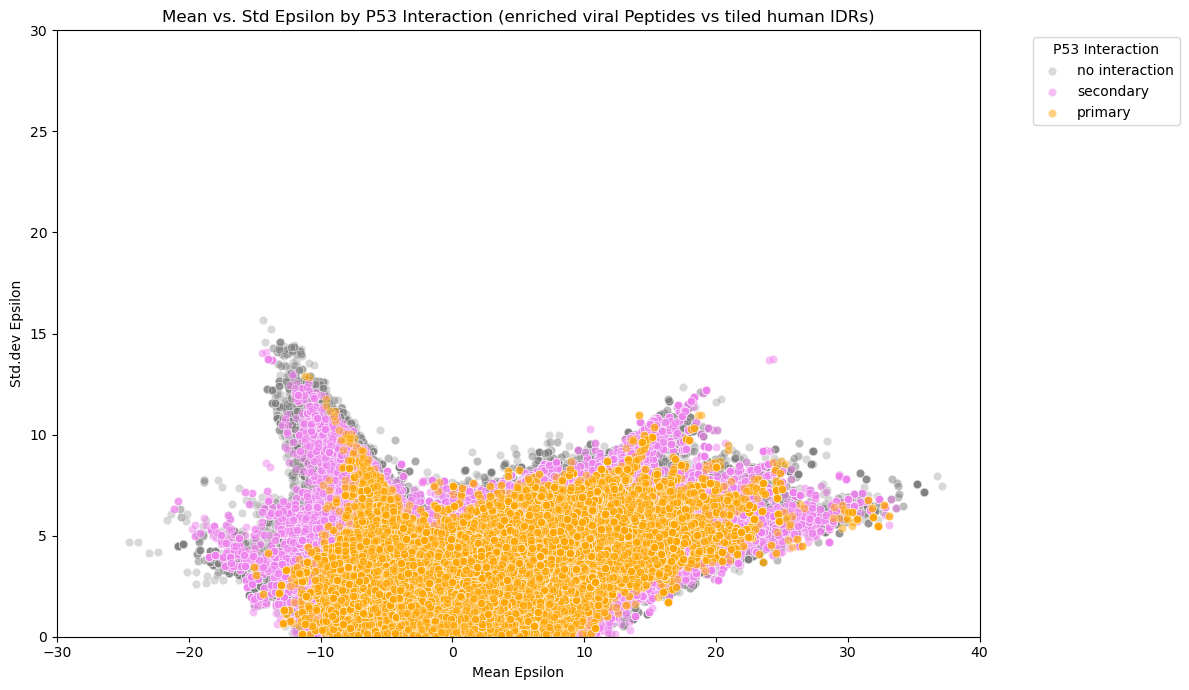

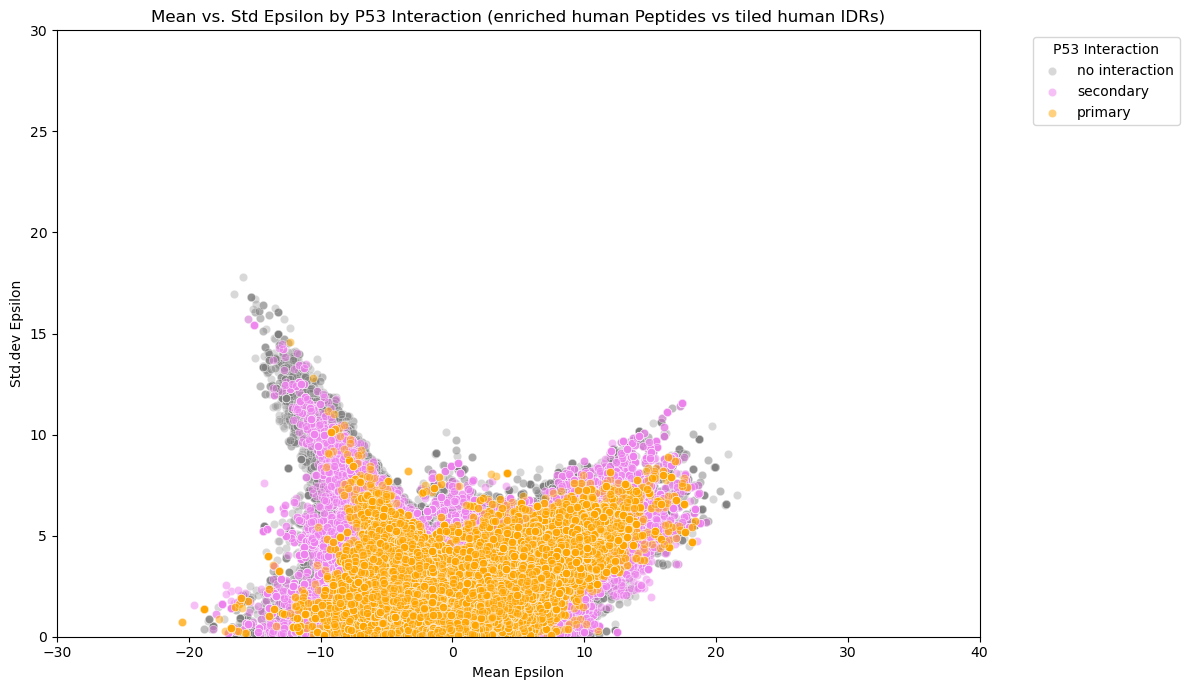

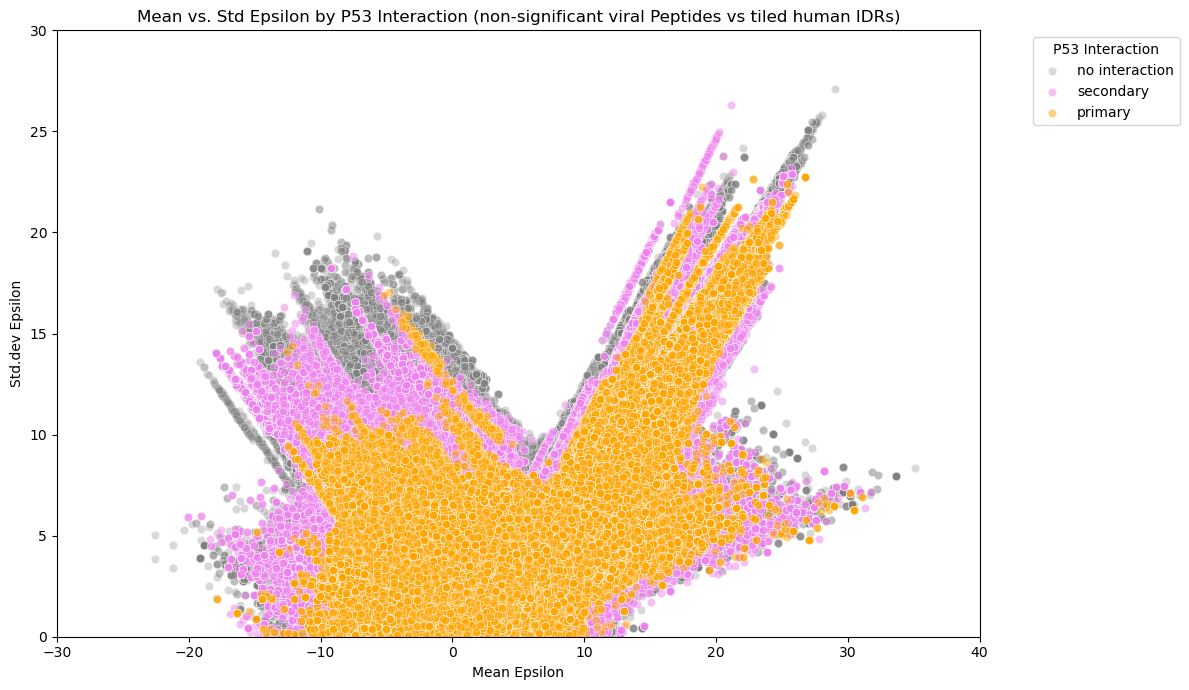

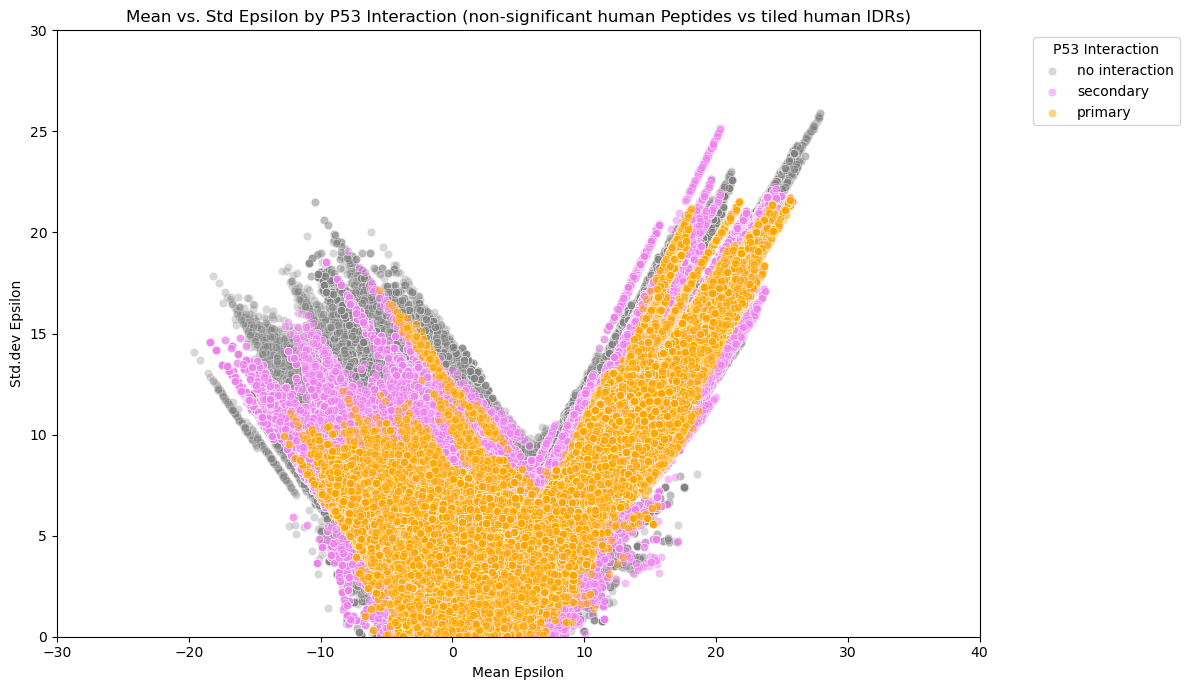

In [5]:
xlim = (-30, 40)
ylim = (0, 30)

enriched_viral_file = 'results/finches_all-enriched-viral-peptide-to-human-tiled-idr-interaction_results.parquet'
enriched_viral_df = load_data(enriched_viral_file)
plot_mean_stddev_scatter_plot(enriched_viral_df, xlim, ylim, "enriched viral Peptides")


enriched_human_file = 'results/finches_all27-enriched-human-peptide-to-human-tiled-idr-interaction_results.parquet'
enriched_human_df = load_data(enriched_human_file)
plot_mean_stddev_scatter_plot(enriched_human_df, xlim, ylim, "enriched human Peptides")


non_enriched_viral_file = 'results/finches_non-enriched-viral-peptide-to-human-tiled-idr-interaction_results.parquet'
non_enriched_viral_df = load_data(non_enriched_viral_file)
plot_mean_stddev_scatter_plot(non_enriched_viral_df, xlim, ylim, "non-significant viral Peptides")


non_enriched_human_file = 'results/finches_non-enriched-human-peptide-to-human-tiled-idr-interaction_results.parquet'
non_enriched_human_df = load_data(non_enriched_human_file)
plot_mean_stddev_scatter_plot(non_enriched_human_df, xlim, ylim, "non-significant human Peptides")


Shape before filtering for duplicates: (1694, 12)
Shape after filtering for duplicates: (1033, 12)


/scratch/1384762.1.apolkovnikov-pub/ipykernel_2453689/1165137410.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['P53_Interaction'] = df_filtered['s2_id'].map(id_to_p53_interaction_map)


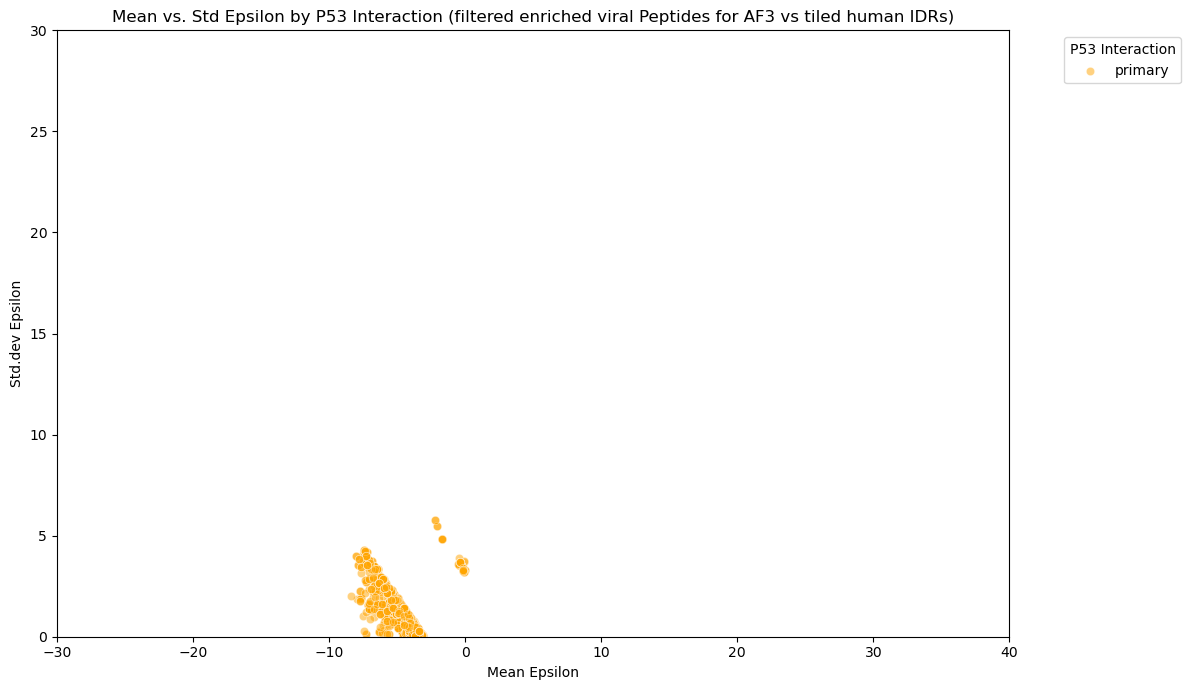

In [11]:
xlim = (-30, 40)
ylim = (0, 30)

enriched_viral_file = 'results/finches_all-enriched-viral-peptide-to-human-tiled-idr-interaction_results.parquet'
df = load_data(enriched_viral_file)

# This file includes all the top viral hits from the RITA experiment
significant_viral_tiles = pd.read_csv("data/tiling_peptides_thresholded_foldchange.csv") 
viral_ids = significant_viral_tiles['tileID']

columns_to_check = ['mf_s1_s2', 'mf_s2_s1', 'cf_s1_s2', 'cf_s2_s1']
df = df[~((df[columns_to_check] > -3) & (df[columns_to_check] < 3)).any(axis=1)]
#df = df[(df[columns_to_check] < -3).all(axis=1)]
df_filtered = df[((df['s1_id'].apply(lambda x: '_'.join(x.split('_')[:2]))).isin(viral_ids)) & (df['P53_Interaction'] == 'primary') & (df['interaction_type'] == 'attraction')]


df_interactions = pd.read_csv('data/human-proteom-interactions.csv')

# Create a mapping Series from df_interactions
# The index will be 'ID' and the values will be 'P53_Interaction'
id_to_p53_interaction_map = df_interactions.set_index('ID')['P53_Interaction']
df_filtered['P53_Interaction'] = df_filtered['s2_id'].map(id_to_p53_interaction_map)

print(f"Shape before filtering for duplicates: {df_filtered.shape}")
df_filtered_unique = df_filtered.drop_duplicates(subset=['s1_id', 's2_id'])
print(f"Shape after filtering for duplicates: {df_filtered_unique.shape}")

plot_mean_stddev_scatter_plot(df_filtered_unique, xlim, ylim, "filtered enriched viral Peptides for AF3")



Shape before filtering for duplicates: (0, 12)
Shape after filtering for duplicates: (0, 12)


/scratch/1384762.1.apolkovnikov-pub/ipykernel_2453689/2291760522.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='P53 Interaction', bbox_to_anchor=(1.05, 1), loc='upper left')


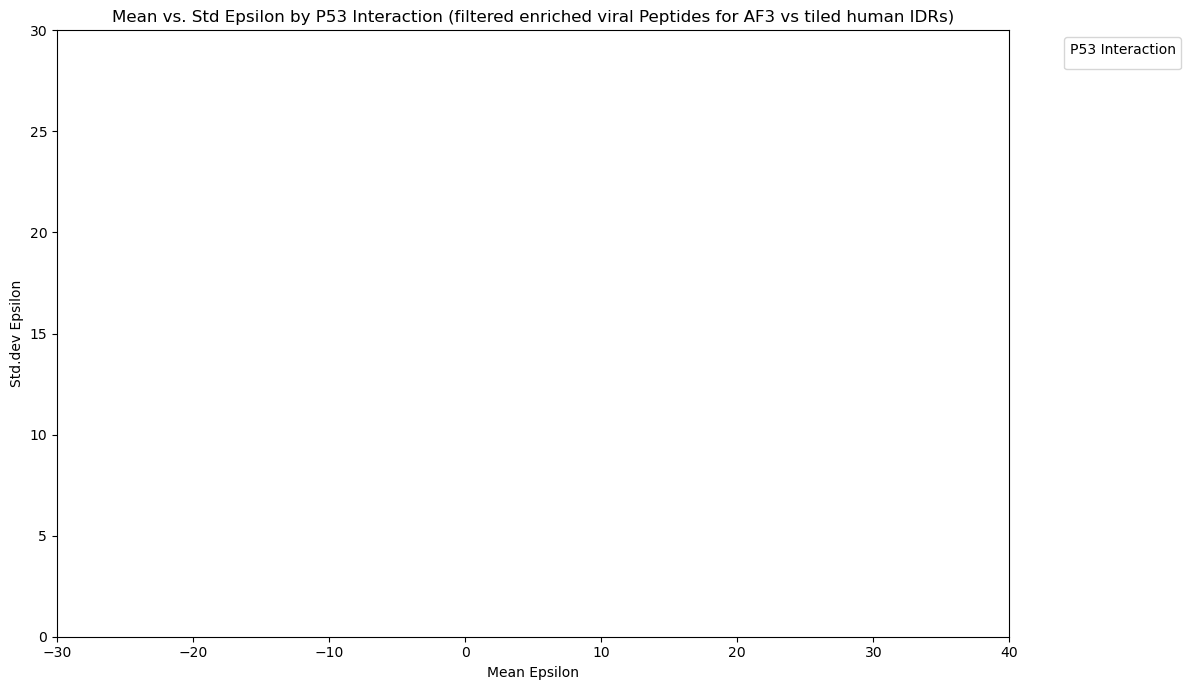

In [6]:
xlim = (-30, 40)
ylim = (0, 30)

non_enriched_viral_file = 'results/finches_non-enriched-viral-peptide-to-human-tiled-idr-interaction_results.parquet'
df = load_data(non_enriched_viral_file)

# This file includes all the top viral hits from the RITA experiment
significant_viral_tiles = pd.read_csv("data/tiling_peptides_thresholded_foldchange.csv") 
viral_ids = significant_viral_tiles['tileID']

columns_to_check = ['mf_s1_s2', 'mf_s2_s1', 'cf_s1_s2', 'cf_s2_s1']
df = df[~((df[columns_to_check] > -3) & (df[columns_to_check] < 3)).any(axis=1)]
df_filtered = df[((df['s1_id'].apply(lambda x: '_'.join(x.split('_')[:2]))).isin(viral_ids)) & (df['P53_Interaction'] == 'primary') & (df['interaction_type'] == 'attraction')]


df_interactions = pd.read_csv('data/human-proteom-interactions.csv')

# Create a mapping Series from df_interactions
# The index will be 'ID' and the values will be 'P53_Interaction'
id_to_p53_interaction_map = df_interactions.set_index('ID')['P53_Interaction']

df_filtered['P53_Interaction'] = df_filtered['s2_id'].map(id_to_p53_interaction_map)

print(f"Shape before filtering for duplicates: {df_filtered.shape}")
df_filtered_unique = df_filtered.drop_duplicates(subset=['s1_id', 's2_id'])
print(f"Shape after filtering for duplicates: {df_filtered_unique.shape}")

plot_mean_stddev_scatter_plot(df_filtered_unique, xlim, ylim, "filtered enriched viral Peptides for AF3")


# Normalize Force Fields with Variance, then check distribution of P53 interaction in selected area

In [3]:
enriched_viral_file = 'results/RITA_experiment_results/finches_all-enriched-viral-peptide-to-human-tiled-idr-interaction_results.parquet'
df = load_data(enriched_viral_file)

# --- Z-score normalization ---

# Calculate mean (average) and standard deviation (usual spread) for each column
mf1_mean = df['mf_s1_s2'].mean(skipna=True)
mf1_std = df['mf_s1_s2'].std(skipna=True)

mf2_mean = df['mf_s2_s1'].mean(skipna=True)
mf2_std = df['mf_s2_s1'].std(skipna=True)

cf1_mean = df['cf_s1_s2'].mean(skipna=True)
cf1_std = df['cf_s1_s2'].std(skipna=True)

cf2_mean = df['cf_s2_s1'].mean(skipna=True)
cf2_std = df['cf_s2_s1'].std(skipna=True)

# Apply the Z-score normalization: (value - mean) / standard_deviation
df['mf_s1_s2_norm_zscore'] = (df['mf_s1_s2'] - mf1_mean) / mf1_std
df['mf_s2_s1_norm_zscore'] = (df['mf_s2_s1'] - mf2_mean) / mf2_std
df['cf_s1_s2_norm_zscore'] = (df['cf_s1_s2'] - cf1_mean) / cf1_std
df['cf_s2_s1_norm_zscore'] = (df['cf_s2_s1'] - cf2_mean) / cf2_std


/scratch/1646410.1.apolkovnikov-pub/ipykernel_3336459/2451257023.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/projectnb/cancergrp/Philipp/.conda/envs/my_analysis_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


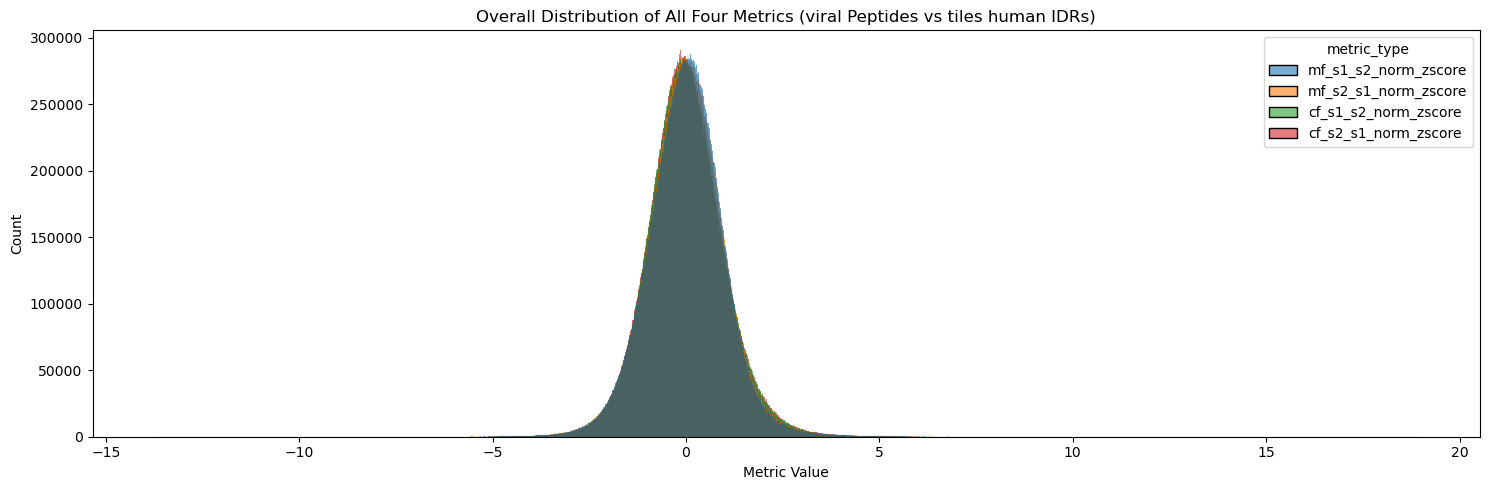

In [4]:
df_melted = df.melt(id_vars=['s1_id', 's2_id'],
                    value_vars=['mf_s1_s2_norm_zscore', 'mf_s2_s1_norm_zscore', 'cf_s1_s2_norm_zscore', 'cf_s2_s1_norm_zscore'],
                    var_name='metric_type',
                    value_name='value')

# Overall distribution of each metric
plt.figure(figsize=(15, 5))
ax = sns.histplot(data=df_melted, x='value', hue='metric_type', palette='tab10', alpha=0.6)
plt.title('Overall Distribution of All Four Metrics (viral Peptides vs tiles human IDRs)')
plt.xlabel('Metric Value')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [36]:
cf12_1per = len(df['cf_s1_s2_norm_zscore']) * 0.01
print(cf12_1per > len(df[df['cf_s1_s2_norm_zscore'] < -2.2 ] )  )
len(df[df['cf_s1_s2_norm'] < -2.2 ] )

True


2330021

In [43]:
mf12_1per = len(df['mf_s1_s2_norm_zscore']) * 0.01
print(mf12_1per > len(df[df['mf_s1_s2_norm_zscore'] < -2.2 ] )  )
len(df[df['cf_s1_s2_norm'] < -2.2 ] )

True


4101788

Shape before filtering for duplicates: (40688, 16)
Shape after filtering for duplicates: (27410, 16)


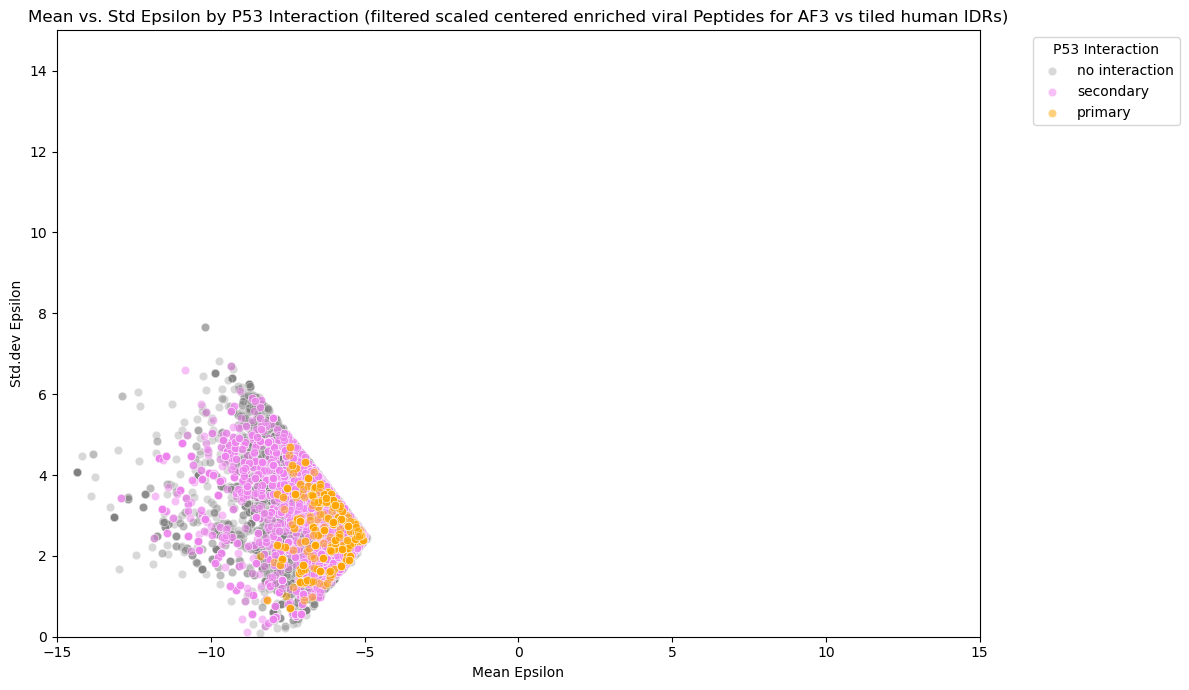

In [5]:
xlim = (-15, 15)
ylim = (0, 15)

# This file includes all the top viral hits from the RITA experiment
significant_viral_tiles = pd.read_csv("data/tiling_peptides_thresholded_foldchange.csv") 
viral_ids = significant_viral_tiles['tileID']

columns_to_check = ['mf_s1_s2_norm_zscore', 'mf_s2_s1_norm_zscore', 'cf_s1_s2_norm_zscore', 'cf_s2_s1_norm_zscore']
df = df[(df[columns_to_check] < -2.2).all(axis=1)]
#df_filtered = df[((df['s1_id'].apply(lambda x: '_'.join(x.split('_')[:2]))).isin(viral_ids)) & (df['P53_Interaction'] == 'primary') & (df['interaction_type'] == 'attraction')]
df_filtered = df[(df['s1_id'].apply(lambda x: '_'.join(x.split('_')[:2]))).isin(viral_ids)]

print(f"Shape before filtering for duplicates: {df_filtered.shape}")
df_filtered_unique = df_filtered.drop_duplicates(subset=['s1_id', 's2_id'])
print(f"Shape after filtering for duplicates: {df_filtered_unique.shape}")

plot_mean_stddev_scatter_plot(df_filtered_unique, xlim, ylim, "filtered scaled centered enriched viral Peptides for AF3")



In [6]:
df_filtered = df

print(f"Shape before filtering for duplicates: {df_filtered.shape}")
df_filtered_unique = df_filtered.drop_duplicates(subset=['s1_id', 's2_id'])
print(f"Shape after filtering for duplicates: {df_filtered_unique.shape}")

Shape before filtering for duplicates: (493953, 16)
Shape after filtering for duplicates: (314545, 16)


--- Stage A: Whole Dataset ---
Total rows: 266282994


/scratch/1392238.1.apolkovnikov-pub/ipykernel_2714700/1213943739.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=interaction_counts.index, y=interaction_counts.values, ax=ax, palette='viridis')


P53_Interaction counts:
 P53_Interaction
no interaction    220764516
secondary          40659600
primary             4858878
Name: count, dtype: int64
------------------------------

--- Stage B: Z-score < -2.2 Filter ---
Rows after Z-score filter: 493953
P53_Interaction counts:
 P53_Interaction
no interaction    394742
secondary          90946
primary             8265
Name: count, dtype: int64
------------------------------

--- Stage C: Further Filtered & Deduplicated ---
Rows after Z-score filter: 493953
Rows after viral_ids, primary, attraction filter: 40688
Rows after deduplication: 40670


/scratch/1392238.1.apolkovnikov-pub/ipykernel_2714700/1213943739.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=interaction_counts.index, y=interaction_counts.values, ax=ax, palette='viridis')
/scratch/1392238.1.apolkovnikov-pub/ipykernel_2714700/1213943739.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=interaction_counts.index, y=interaction_counts.values, ax=ax, palette='viridis')


P53_Interaction counts:
 P53_Interaction
no interaction    32022
secondary          7998
primary             650
Name: count, dtype: int64
------------------------------



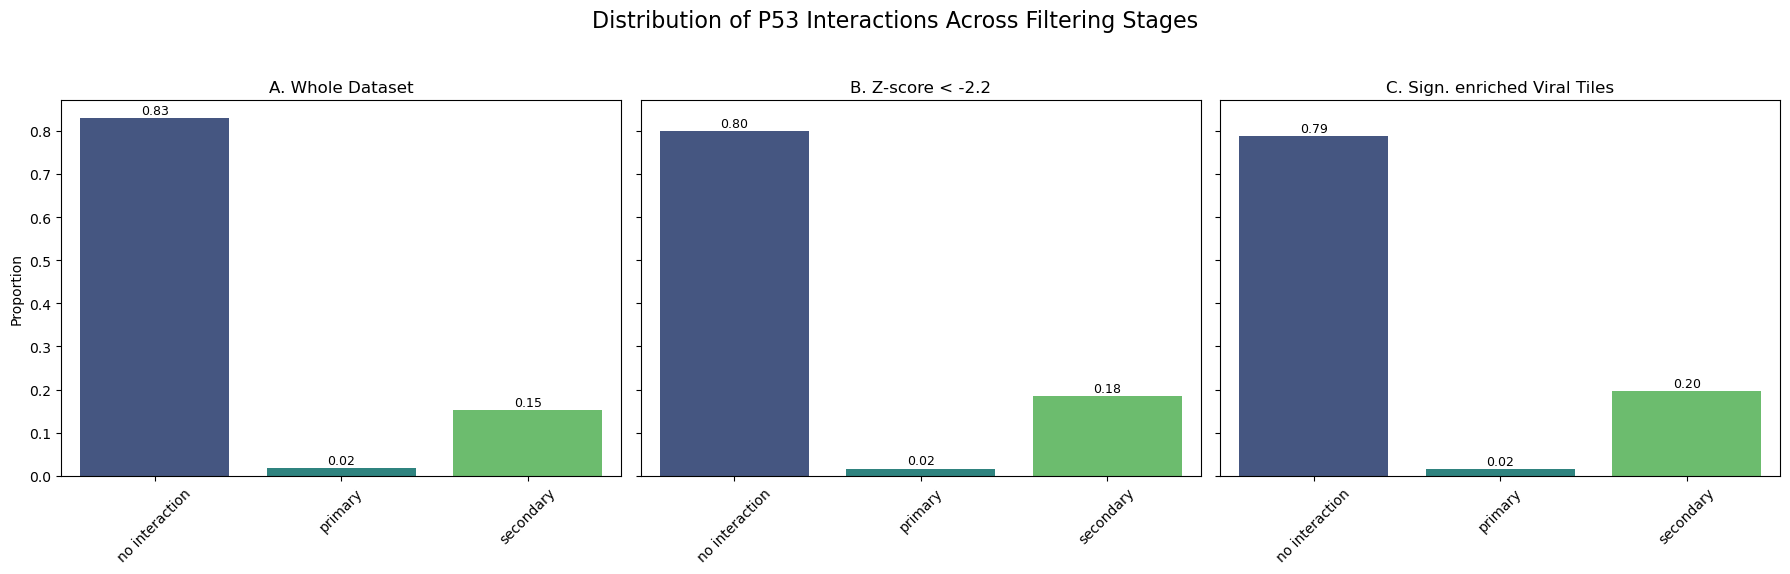

In [51]:
significant_viral_tiles = pd.read_csv("data/tiling_peptides_thresholded_foldchange.csv") 
viral_ids = significant_viral_tiles['tileID'].unique()

# --- 1. Define a plotting function to avoid repetition ---
def plot_interaction_distribution(data_to_plot, title, ax):
    """
    Plots the normalized distribution of 'P53_Interaction' categories.
    Ensures all three categories are shown even if their count is zero.
    """
    # Calculate proportions, reindex to ensure all categories are present
    interaction_counts = data_to_plot['P53_Interaction'].value_counts(normalize=True)
    full_categories = pd.Series(0.0, index=['primary', 'secondary', 'no interaction'])
    interaction_counts = full_categories.add(interaction_counts, fill_value=0)

    sns.barplot(x=interaction_counts.index, y=interaction_counts.values, ax=ax, palette='viridis')
    ax.set_title(title, fontsize=12)
    ax.set_ylabel('Proportion')
    ax.set_xlabel('') # Clear x-label, as it's repetitive
    ax.tick_params(axis='x', rotation=45) # Rotate x-axis labels for better readability

    # Add proportion labels on top of the bars
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 0.01,
                f'{height:.2f}', ha="center", fontsize=9)

# --- 2. Set up the plot for comparison ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True) # 1 row, 3 columns, shared y-axis
fig.suptitle('Distribution of P53 Interactions Across Filtering Stages', fontsize=16)


# --- Stage A: Whole Dataset ---
print("--- Stage A: Whole Dataset ---")
print(f"Total rows: {len(df)}")
if not df.empty:
    plot_interaction_distribution(df, 'A. Whole Dataset', axes[0])
    print("P53_Interaction counts:\n", df['P53_Interaction'].value_counts())
else:
    print("DataFrame is empty. Cannot plot whole dataset.")
    axes[0].set_title('A. Whole Dataset (No Data)')
    axes[0].text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes)
print("-" * 30 + "\n")

# --- Stage B: Filter for Z-score < -2.2 (best <1% of data) ---
print("--- Stage B: Z-score < -2.2 Filter ---")
columns_to_check = ['mf_s1_s2_norm_zscore', 'mf_s2_s1_norm_zscore', 'cf_s1_s2_norm_zscore', 'cf_s2_s1_norm_zscore']
df_zscore_filtered = df[(df[columns_to_check] < -2.2).all(axis=1)].copy() # .copy() to avoid SettingWithCopyWarning

print(f"Rows after Z-score filter: {len(df_zscore_filtered)}")
if not df_zscore_filtered.empty:
    plot_interaction_distribution(df_zscore_filtered, 'B. Z-score < -2.2', axes[1])
    print("P53_Interaction counts:\n", df_zscore_filtered['P53_Interaction'].value_counts())
else:
    print("No data after Z-score filter. Cannot plot.")
    axes[1].set_title('B. Z-score < -2.2 (No Data)')
    axes[1].text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)
print("-" * 30 + "\n")


# --- Stage C: Further Filtered (Viral Tiles) & Deduplicated ---
print("--- Stage C: Further Filtered & Deduplicated ---")

if not df_zscore_filtered.empty:
    # Prepare s1_id for matching with viral_ids
    # This extracts the 'PROT_001' part from 'PROT_001_TILE_A'
    df_zscore_filtered['s1_id_prefix'] = df_zscore_filtered['s1_id'].apply(lambda x: '_'.join(x.split('_')[:2]))

    df_final_filtered = df_zscore_filtered[(df_zscore_filtered['s1_id_prefix'].isin(viral_ids))].copy()

    # Remove duplicates as requested
    df_final_filtered_deduplicated = df_final_filtered.drop_duplicates().copy()

    print(f"Rows after Z-score filter: {len(df_zscore_filtered)}")
    print(f"Rows after viral_ids, primary, attraction filter: {len(df_final_filtered)}")
    print(f"Rows after deduplication: {len(df_final_filtered_deduplicated)}")

    if not df_final_filtered_deduplicated.empty:
        plot_interaction_distribution(df_final_filtered_deduplicated,
                                      'C. Sign. enriched Viral Tiles', axes[2])
        print("P53_Interaction counts:\n", df_final_filtered_deduplicated['P53_Interaction'].value_counts())
    else:
        print("No data after further filtering and deduplication. Cannot plot.")
        axes[2].set_title('C. Final Filtered (No Data)')
        axes[2].text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center', transform=axes[2].transAxes)
else:
    print("Previous stage (Z-score filtered) had no data, so further filtering is not possible.")
    axes[2].set_title('C. Final Filtered (No Data)')
    axes[2].text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center', transform=axes[2].transAxes)

print("-" * 30 + "\n")

# --- Display the plots ---
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for the main title
plt.show()